Import Libraries and load in data:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import math
from collections import Counter

file_path = '/home/eric/sim/WWLegend/Archive/Neutrontaggerruns/Warwick without ArgonModerator/'
""" Amount is required to know how many entries belong to each neutron. 
    nPMMA is an array where each entry says how many photon timestamp belong to that neutron.
    Time for the time entries. Each entry is one photon timestamp.
    PMMA means the PMMA geometry, other geometries are possible, currently commented out."""
nPMMA = np.loadtxt(file_path + "PMMAAmount.txt", dtype=float, delimiter=',', skiprows=5, unpack=True)
timePMMA = np.loadtxt(file_path + "PMMATimes.txt", dtype=float, skiprows=5, delimiter=',', unpack=True)
nPMMAFoil = np.loadtxt(file_path + "/Foil On PMMA/PMMAAmount.txt", dtype=float, delimiter=',', skiprows=5, unpack=True)
timePMMAFoil = np.loadtxt(file_path + "/Foil On PMMA/PMMATimes.txt", dtype=float, skiprows=5, delimiter=',', unpack=True)
""" no carries the id to which shower each neutron belongs. """
no, x, y, z, ekin, NeutronCaptureTimeDelay = np.loadtxt(file_path + "ShowerIDs.txt", dtype=float, delimiter=',', skiprows=1, unpack=True)
#honestly no idea what this was for again
#identifierPMMA, useless, session, session2, bruh, bruh2 = np.loadtxt("d:/Eric/Data Dump/Master/FullTimeStuff/PMMARun.txt", dtype=float, delimiter=',', unpack=True)
#identifierWater, useless, session, session2, bruh, bruh2 = np.loadtxt("d:/Eric/Data Dump/Master/FullTimeStuff/WaterRun.txt", dtype=float, delimiter=',', unpack=True)

Functions to sort and organize data

In [5]:
def subarray_it_up(n, time, id):
    """ Takes array of number of timestamps per neutron, the timestamps 
        and the array of ids of the corresponding Shower of the neutron. 
        Returns Array where each subarray corresponds to all 
        Timestamps of one Shower. Size should be amount of Showers."""
    unique, counts = np.unique(id, return_counts=True)
    print(np.size(unique))
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    cum_n = np.cumsum(n)
    cum_n = cum_n.astype(int)
    subarrays = [time[0 if i == 0 else cum_n[(cum_counts[i-1]) - 1]:cum_n[(cum_counts[i])-1]] for i in range(len(counts))]
    return subarrays

def mult_to_phot(mult, Npmt):
    """ Uses surface of Hit area and single PMT area (hardcoded).
        Takes the given multiplicity of PMTs + deployed amount of PMTs.
        Returns how many photon hits are required to fullfill multiplicity
        assuming isotropic hit location."""
    F = 467
    Fpmt = 0.05
    return (mult * 5 * F /( Npmt * Fpmt))

def histlist(AllShowers, window, timeMax):
    """ Takes whole Shower array and divides each Shower 
        in time windows of size "window" up to timeMax.
        Returns Array with histogram for each Shower
        with window/timeMax bins and max range timeMax."""
    b = int(timeMax/window)
    hists_list = []
    for Shower in AllShowers:
        x, y = np.histogram(Shower, bins=b, range=(0, timeMax))
        hists_list.append(x)
    hists_array = np.array(hists_list)
    return hists_array

def bins_over_thresh(arr, threshold):
    """ Takes single array and a threshold.
        Returns how many entries are above threshold"""
    res = np.sum(arr > threshold)
    return res

def distinguished_neutrons(AllShowers, mult, Npmt, window, timeMax):
    """ Takes whole Shower array, a given multiplicity, 
        given Amount of PMTs, size of coincidence intervall
        (in ns) and maximum time delay (in ns).
        Returns an array where each entry is the amount of neutrons
        of that Shower that would be detected with these 4 conditions.
    """
    hists_array = histlist(AllShowers, window,timeMax)
    threshold = mult_to_phot(mult, Npmt)
    results_array = np.array([])
    for i in hists_array:
        results_array = np.append(results_array, bins_over_thresh(i, threshold))
    return results_array

def random_rate(mult, Npmt, window, timeMax):
    """ Calculates the random rate of PMTs from the
        required multiplicity threshold, Amount of PMTs,
        coincidence Intervall and maximum time delay after
        muon. The darkrate is hardcoded (default 5000 Hz)."""
    log_numer = math.log(np.math.factorial(Npmt)) # Have to use logs as numbers get way too large
    log_denom = math.log(np.math.factorial(mult))
    log_denom2 = math.log(np.math.factorial(Npmt-mult))
    D = 5000 # random rate 5000 hz
    rate = np.exp(log_numer - log_denom - log_denom2 + mult * math.log(D) + (mult - 1) * math.log(window * 10**-9)) # in Hz
    randoms = rate * timeMax * 10**-9 # timeMax in nanoseconds
    return randoms

#Returns how many showers have seen more than x neutrons.
def more_than_x_Neutrons(neutrons, x):
    """ Takes array "neutrons" and threshold x.
        Returns the percentage of entries that
        are above threshold."""
    size = np.size(neutrons)
    return (np.sum(neutrons >= x) / size)

#Returns the entire Array for all multiplicitys
def more_than_x_Array(AllShowers, x, multiplicitys):
    """ Takes whole Shower array, neutron threshold x and array of multiplicities.
        Returns an array that has an entry for each multiplicity giving the percentage
        of Showers that would be detected with given multiplicity and neutron threshold.
        Other Parameters (Amount of PMTs, coincidence intervall, max time delay) are 
        hardcoded."""
    results_array = np.array([])
    for i in multiplicitys:
        neutrons = distinguished_neutrons(AllShowers=AllShowers,mult=i, Npmt=400, window=200, timeMax=200000)
        results_array = np.append(results_array, more_than_x_Neutrons(neutrons,x))
    return results_array

def random_rates_array(multiplicitys):
    """ Takes an array of multiplicites.
        Returns array with statistical PMT
        random rate per multiplicity."""
    results_array = np.array([])
    for i in multiplicitys:
        i = i.astype(int)
        rr = random_rate(mult=i, Npmt=400, window=200, timeMax=200000)
        results_array = np.append(results_array, rr)
    return results_array


Here do all the time consuming steps and calculations etc

In [ ]:
multiplicitys = np.linspace(2,8,7)
subPMMA = subarray_it_up(nPMMA, timePMMA, no)
subPMMAFoil = subarray_it_up(nPMMAFoil, timePMMAFoil, no)

PMMA1 = more_than_x_Array(AllShowers = subPMMA,x=1, multiplicitys = multiplicitys)
PMMA2 = more_than_x_Array(AllShowers = subPMMA, x=2, multiplicitys = multiplicitys)
PMMA3 = more_than_x_Array(AllShowers = subPMMA,x=3, multiplicitys = multiplicitys)
PMMAFoil1 = more_than_x_Array(AllShowers = subPMMAFoil,x=1, multiplicitys = multiplicitys)
PMMAFoil2 = more_than_x_Array(AllShowers = subPMMAFoil,x=2, multiplicitys = multiplicitys)
PMMAFoil3 = more_than_x_Array(AllShowers = subPMMAFoil,x=3, multiplicitys = multiplicitys)

446
446


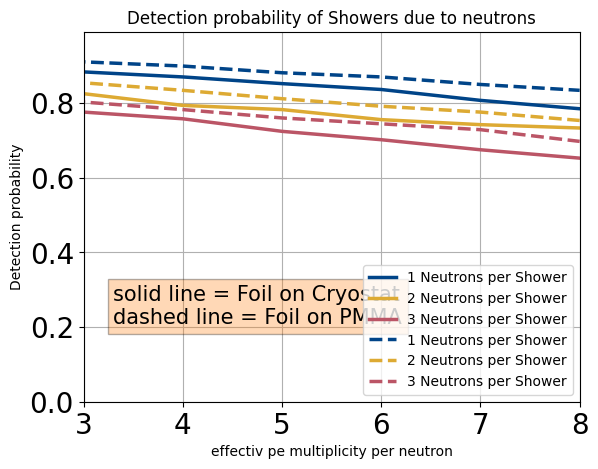

In [7]:
fig, ax1 = plt.subplots()

ax1.plot(multiplicitys, PMMA1, color = "#004488", linewidth=2.5 ,  label="1 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMA2, color = "#DDAA33", linewidth=2.5 , label="2 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMA3, color = "#BB5566", linewidth=2.5 , label="3 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMAFoil1, color = "#004488", linewidth=2.5 , linestyle = "--",  label="1 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMAFoil2, color = "#DDAA33", linewidth=2.5 , linestyle = "--", label="2 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMAFoil3, color = "#BB5566", linewidth=2.5 , linestyle = "--", label="3 Neutrons per Shower"  )


ax1.set_xlabel('effectiv pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of Showers due to neutrons')
ax1.set_xlim(xmin = 3, xmax= 8)
ax1.set_ylim(ymin=0, ymax= 0.99)
ax1.grid()

plt.tick_params(axis='both', labelsize=20)


ax1.legend(loc='lower right')

info_lines2 = [
    "solid line = Foil on Cryostat",
    "dashed line = Foil on PMMA"
    ]
info_text2 = '\n'.join(info_lines2)

ax1.text(0.06, 0.21, info_text2, transform=plt.gca().transAxes, bbox=dict(facecolor='C1', alpha=0.3),fontsize=15)

plt.tick_params(axis='both', labelsize=20)
plt.savefig("/home/eric/sim/WWLegend/Plots/EfficiencyNoFoil.png")
plt.show()